In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [8]:
file = r'/Users/shiva/Desktop/Fall_Quarter_2023/ECS_171/Mulit-class Image classification/cifar-10-batches-py/batches.meta'
batches_meta_file = unpickle(file)
print(batches_meta_file)

data_batch_1_file = r'/Users/shiva/Desktop/Fall_Quarter_2023/ECS_171/Mulit-class Image classification/cifar-10-batches-py/data_batch_1'
dataset_1 = unpickle(data_batch_1_file)
#The size of the 1st data batch is (10000 , 3072):- It contains 10000 images and each image as 3072 numerical entries:- 1024 for Red, Green, Blue respectively.
image = dataset_1['data'][0]
# In the reshape function, the first argument represent the color scaling we are using, for our case, since we have colored image, therefore the color code is 3. And our each image is of the size 32 x 32 pixels.
image = image.reshape(3,32,32)
#print('After reshaping: ', image)
# the standard order of the axes is 0, 1, 2 which represents:- width x height x no. of channels. 
image = image.transpose(1,2,0)

{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


10000


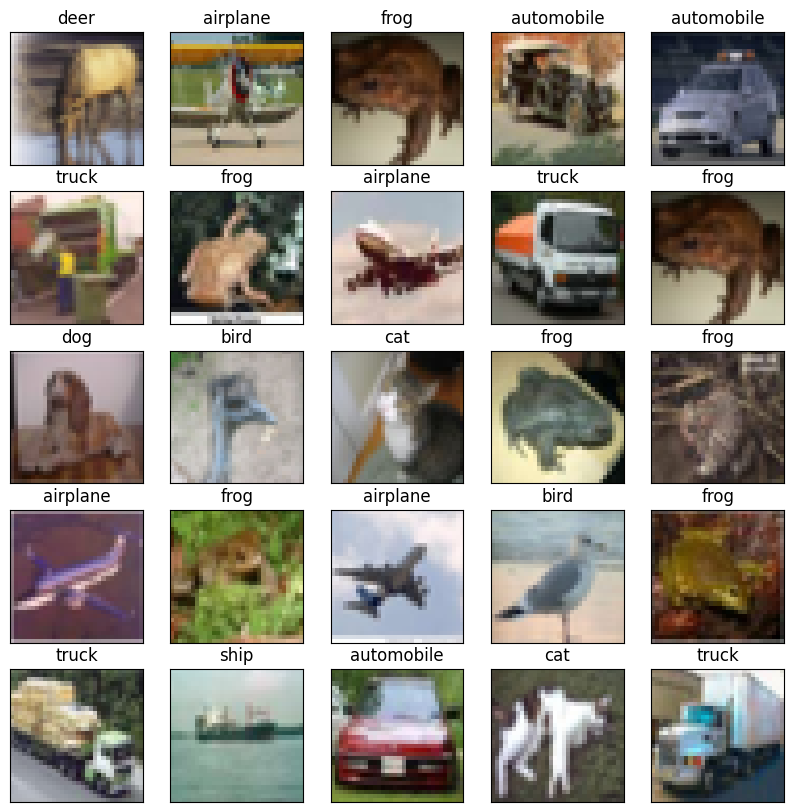

In [7]:
# Python 3 program to visualize 4th image
import matplotlib.pyplot as plt
import numpy as np
# take the images data from batch data
images = dataset_1['data']
print(len(images))
# reshape and transpose the images
# the arguments to reshape function are of the form (nb_samples, nb_channels, width, height)
images = images.reshape(len(images),3,32,32).transpose(0, 2, 3, 1)
# take labels of the images 
labels = dataset_1['labels']
# label names of the images
label_names = batches_meta_file['label_names']


# display random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
# take labels for these images only
labels = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()